In [3]:
from pydrake.solvers import MathematicalProgram
import numpy as np
import matplotlib.pyplot as plt

### Define our dynamic bicycle model parameters

In [16]:
"""
Solves a simple optimization problem
       min x(0)^2 + x(1)^2
subject to x(0) + x(1) = 1
           x(0) < x(1)
"""
from pydrake.solvers import Solve
# Set up the optimization problem.
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] + x[1] == 1.5)
prog.AddConstraint(x[0] <= x[1] - 0.6)
prog.AddCost(x[0] **2 + x[1] ** 2)

# Now solve the optimization problem.
result = Solve(prog)

# print out the result.
print("Success? ", result.is_success())
# Print the solution to the decision variables.
print('x* = ', result.GetSolution(x))
# Print the optimal cost.
print('optimal cost = ', result.get_optimal_cost())
# Print the name of the solver that was called.
print('solver is: ', result.get_solver_id().name())


Success?  True
x* =  [0.45 1.05]
optimal cost =  1.3050000000000006
solver is:  OSQP


Minimum value (lower bound): -1.0316284603955175
Minimum sampled value: -1.0311555412242377


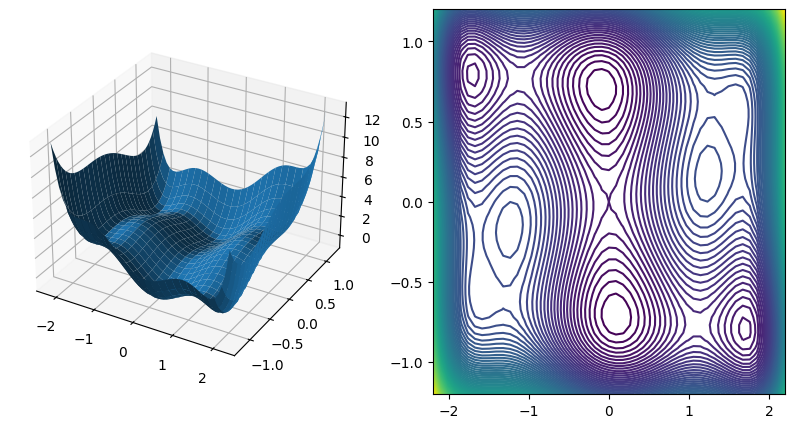

None

In [17]:
def sos_six_hump_camel():
    prog = MathematicalProgram()
    v = prog.NewIndeterminates(2, "x")
    x = v[0]
    y = v[1]

    # This is the famous "six-hump camel back function".  It has six local
    # minima, two of them being global minima.
    p = (
        4 * x**2
        + x * y
        - 4 * y**2
        - 2.1 * x**4
        + 4 * y**4
        + x**6 / 3
    )

    # Find the minimum value by adding a sums of squares constraint, via
    #   for all x, p(x) >= pmin
    # which we write as
    #   p(x) - pmin is sos.
    pmin = prog.NewContinuousVariables(1, "pmin")[0]
    prog.AddSosConstraint(p - pmin)

    # Maximize pmin.
    prog.AddCost(-pmin)

    result = Solve(prog)
    assert result.is_success()
    print("Minimum value (lower bound): " + str(result.GetSolution(pmin)))

    # Now, let's plot it.
    fig = plt.figure(figsize=(10, 5))
    ax0 = fig.add_subplot(121, projection="3d")
    ax1 = fig.add_subplot(122)
    xs = np.linspace(-2.2, 2.2, 51)
    ys = np.linspace(-1.2, 1.2, 51)
    [X, Y] = np.meshgrid(xs, ys)
    P = (
        4 * X**2
        + X * Y
        - 4 * Y**2
        - 2.1 * X**4
        + 4 * Y**4
        + X**6 / 3
    )
    ax0.plot_surface(X, Y, P)
    ax1.contour(X, Y, P, 100)

    print("Minimum sampled value: " + str(np.min(P)))
    display(plt.show())


sos_six_hump_camel()

In [19]:
import numpy as np
from pydrake.all import (
    Jacobian,
    MathematicalProgram,
    RegionOfAttraction,
    Solve,
    SymbolicVectorSystem,
    Variable,
    Variables,
)

def sos_roa():
    prog = MathematicalProgram()

    # define the known parameters
    

    x = prog.NewIndeterminates(1, "x")

    # Define the dynamics and Lyapunov function.
    f = -x + x**3
    V = x.dot(x)
    Vdot = Jacobian([V], x).dot(f)[0]
    rho = 1

    # Define the Lagrange multiplier.
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()

    prog.AddSosConstraint(-Vdot + lambda_ * (V - rho))

    result = Solve(prog)

    assert result.is_success(), "Optimization failed"

    print("Verified that " + str(V) + " < 1 is in the region of attraction.")


sos_roa()

Verified that pow(x(0), 2) < 1 is in the region of attraction.
